# Deep Learning
## Assessment 2 part B
### Ronik Jayakumar
### 24680264

## 1.0 Context
In Part B, we will be exploring into one of the models trained in Part A. The model chosen to go ahead with for Part B is the Mobilenet model due to its exceptional performance in Part A, combined with the overall relative simplicity of the models architecture. This allows us to run large datasets through it with the limited computational power that exists.

## 2.0 Importing Packages

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import models, transforms, datasets
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import urllib.request
import tarfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
from PIL import Image
import shutil
import torch.cuda.amp as amp
from torch.optim.lr_scheduler import ReduceLROnPlateau

## 3.0 Load Dataset
The data has been loaded directly onto google colab to increase processing speed and decrease complexity.

In [2]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

--2024-04-23 05:00:10--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2024-04-23 05:00:11--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  13.0MB/s    in 6m 19s  

2024-04-23 05:06:31 (12.6 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



## 4.0 Data Exploration
The data has been made available in 2 separate folders - images and meta. The images folder consists of 101 subfolders containing images of each class. The meta folder contains readme files specifying class names, training image names, and testing image names.

In [3]:
!tar -xvf food-101.tar.gz

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/695879.jpg
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/

In [4]:
%cd food-101/images
!ls -l

/content/food-101/images
total 3692
drwxr-xr-x 2 3156 320 36864 Sep 21  2013 apple_pie
drwxr-xr-x 2 3156 320 36864 Sep 21  2013 baby_back_ribs
drwxr-xr-x 2 3156 320 36864 Sep 21  2013 baklava
drwxr-xr-x 2 3156 320 36864 Sep 21  2013 beef_carpaccio
drwxr-xr-x 2 3156 320 36864 Sep 21  2013 beef_tartare
drwxr-xr-x 2 3156 320 36864 Sep 21  2013 beet_salad
drwxr-xr-x 2 3156 320 36864 Sep 21  2013 beignets
drwxr-xr-x 2 3156 320 36864 Sep 21  2013 bibimbap
drwxr-xr-x 2 3156 320 32768 Sep 21  2013 bread_pudding
drwxr-xr-x 2 3156 320 36864 Sep 21  2013 breakfast_burrito
drwxr-xr-x 2 3156 320 36864 Sep 21  2013 bruschetta
drwxr-xr-x 2 3156 320 36864 Sep 21  2013 caesar_salad
drwxr-xr-x 2 3156 320 36864 Sep 21  2013 cannoli
drwxr-xr-x 2 3156 320 36864 Sep 21  2013 caprese_salad
drwxr-xr-x 2 3156 320 36864 Sep 21  2013 carrot_cake
drwxr-xr-x 2 3156 320 36864 Jul  9  2014 ceviche
drwxr-xr-x 2 3156 320 36864 Sep 21  2013 cheesecake
drwxr-xr-x 2 3156 320 36864 Sep 21  2013 cheese_plate
drwxr-xr-x 2 3

## 5.0 Data Splitting
The combination of the image folder and the meta folder transforms into our training and testing data complete with class labels. In this section, the images will be associated to their particular class and split into training and testing sets based on defined criteria.

In [5]:
classes_txt_path = '/content/food-101/meta/classes.txt'

with open(classes_txt_path, 'r') as file:
    class_names = [line.strip() for line in file]

images_dir = '/content/food-101/images'

data = {class_name: [] for class_name in class_names}

for root, dirs, files in os.walk(images_dir):
    class_name = os.path.basename(root)
    if class_name in class_names:
        for file in files:
            if file.endswith('.jpg'):
                image_path = os.path.join(root, file)
                data[class_name].append(image_path)

for class_name, images in data.items():
    print(f"Class: {class_name}, Number of images: {len(images)}")

Class: apple_pie, Number of images: 1000
Class: baby_back_ribs, Number of images: 1000
Class: baklava, Number of images: 1000
Class: beef_carpaccio, Number of images: 1000
Class: beef_tartare, Number of images: 1000
Class: beet_salad, Number of images: 1000
Class: beignets, Number of images: 1000
Class: bibimbap, Number of images: 1000
Class: bread_pudding, Number of images: 1000
Class: breakfast_burrito, Number of images: 1000
Class: bruschetta, Number of images: 1000
Class: caesar_salad, Number of images: 1000
Class: cannoli, Number of images: 1000
Class: caprese_salad, Number of images: 1000
Class: carrot_cake, Number of images: 1000
Class: ceviche, Number of images: 1000
Class: cheesecake, Number of images: 1000
Class: cheese_plate, Number of images: 1000
Class: chicken_curry, Number of images: 1000
Class: chicken_quesadilla, Number of images: 1000
Class: chicken_wings, Number of images: 1000
Class: chocolate_cake, Number of images: 1000
Class: chocolate_mousse, Number of images: 1

In [6]:
images_dir = '/content/food-101/images'
meta_dir = '/content/food-101/meta'
train_txt_path = os.path.join(meta_dir, 'train.txt')
test_txt_path = os.path.join(meta_dir, 'test.txt')
output_train_dir = '/content/train_data'
output_test_dir = '/content/test_data'

# Read train.txt and test.txt to get image filenames
def read_image_names(txt_path):
    with open(txt_path, 'r') as file:
        image_names = [line.strip() for line in file]
    return image_names

train_image_names = read_image_names(train_txt_path)
test_image_names = read_image_names(test_txt_path)

# Function to copy/move images based on class labels
def process_images(image_names, output_dir):
    for image_name in image_names:
        class_name, filename = image_name.split('/')
        filename_with_extension = filename + '.jpg'  # Assuming all images are JPEGs
        src_path = os.path.join(images_dir, class_name, filename_with_extension)
        dest_dir = os.path.join(output_dir, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        dest_path = os.path.join(dest_dir, filename_with_extension)
        shutil.copy(src_path, dest_path)

# Process training images
process_images(train_image_names, output_train_dir)

# Process testing images
process_images(test_image_names, output_test_dir)

In [8]:
def list_directory_contents(directory):
    print(f"Contents of directory '{directory}':")
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        num_images = len(os.listdir(class_dir))
        print(f"Class: {class_name}, Number of images: {num_images}")

# List contents of train_data and test_data directories
list_directory_contents('/content/train_data')
list_directory_contents('/content/test_data')

Contents of directory '/content/train_data':
Class: mussels, Number of images: 750
Class: fish_and_chips, Number of images: 750
Class: creme_brulee, Number of images: 750
Class: french_fries, Number of images: 750
Class: cup_cakes, Number of images: 750
Class: tacos, Number of images: 750
Class: eggs_benedict, Number of images: 750
Class: pizza, Number of images: 750
Class: chicken_curry, Number of images: 750
Class: waffles, Number of images: 750
Class: pulled_pork_sandwich, Number of images: 750
Class: spring_rolls, Number of images: 750
Class: paella, Number of images: 750
Class: onion_rings, Number of images: 750
Class: bread_pudding, Number of images: 750
Class: ravioli, Number of images: 750
Class: guacamole, Number of images: 750
Class: pad_thai, Number of images: 750
Class: risotto, Number of images: 750
Class: ice_cream, Number of images: 750
Class: poutine, Number of images: 750
Class: grilled_salmon, Number of images: 750
Class: hamburger, Number of images: 750
Class: cheese

## 6.0 Data Preparation

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
train_dataset = ImageFolder(root='/content/train_data', transform=transform)
test_dataset = ImageFolder(root='/content/test_data', transform=transform)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=0, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=0, pin_memory=True, shuffle=False)

### 6.1 Callback Function

In [7]:
class CustomCallback:
    def __init__(self, early_stop_patience=5, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path='checkpoint.pth', log_dir='logs'):
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        if val_loss < self.best_val_loss: # Early stopping
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
        pass

    def set_model(self, model):
        self.model = model

## 7.0 Display Images based on their Class
10 classes are selected at random and an image from these classes have been displayed to ensure all images have been downloaded and imported properly.

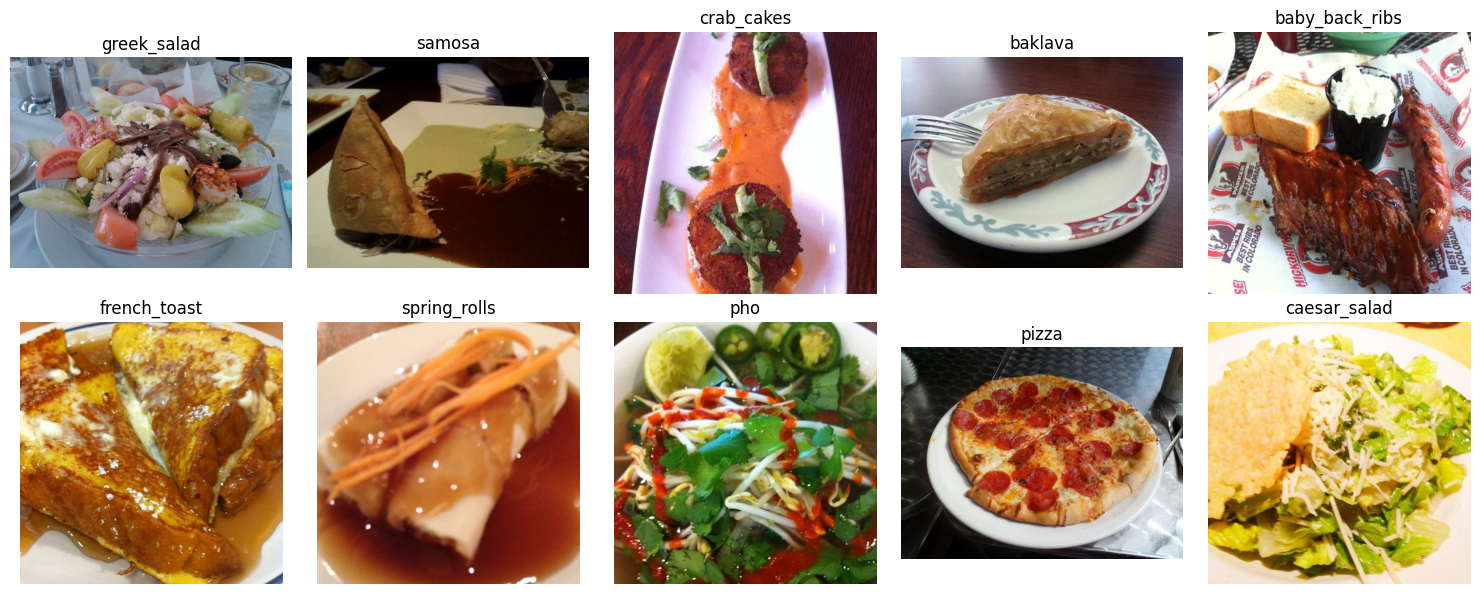

In [12]:
with open(classes_txt_path, 'r') as file:
    class_names = [line.strip() for line in file]

# Choose 10 random classes
random_classes = random.sample(class_names, 10)

# Create a subplot for each class
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axes = axes.flatten()

for i, class_name in enumerate(random_classes):
    # Get a list of image paths for the current class
    class_images_dir = os.path.join(images_dir, class_name)
    class_images = [os.path.join(class_images_dir, img) for img in os.listdir(class_images_dir) if img.endswith('.jpg')]

    # Choose a random image from the class
    random_image = random.choice(class_images)

    # Display the image and its class label
    img = mpimg.imread(random_image)
    axes[i].imshow(img)
    axes[i].set_title(class_name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 8.0 MobileNet Model
Mobilenet is a computer vision model that has been sourced by Google. It is used for classification models and has been chosen in this experiment due to its exceptional results in part A.

In [13]:
mobilenet_model = models.mobilenet_v3_small(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 84.7MB/s]


In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=0, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=0, pin_memory=True, shuffle=False)

In [15]:
# Freeze all layers
for param in mobilenet_model.parameters():
    param.requires_grad = False

In [16]:
# Unfreeze last few layers for fine-tuning
unfreeze_layers = ['features.11', 'classifier.0', 'classifier.3']
for name, param in mobilenet_model.named_parameters():
    if any(layer_name in name for layer_name in unfreeze_layers):
        param.requires_grad = True

In [19]:
# Modify the last fully connected layer based on the number of classes in our dataset
num_classes = 101
mobilenet_model.classifier[-1] = nn.Linear(in_features=mobilenet_model.classifier[-1].in_features, out_features=num_classes)

In [24]:
# Define optimizer with parameters of unfrozen layers only
optimizer = optim.Adam(filter(lambda p: p.requires_grad, mobilenet_model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()
callback = CustomCallback()

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [25]:
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

# Training loop
def train(model, train_loader, optimizer, criterion, device, callback):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_accuracy = correct / total

    return train_loss, train_accuracy

# Evaluation loop
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / total
    test_accuracy = correct / total

    return test_loss, test_accuracy

# Training and evaluation
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(mobilenet_model, train_loader, optimizer, criterion, device, callback)
    test_loss, test_accuracy = evaluate(mobilenet_model, test_loader, criterion, device)

    # Save the metrics
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {100 * test_accuracy:.2f}%")

Epoch [1/10]
Train Loss: 2.2287, Train Accuracy: 44.52%
Test Loss: 1.5197, Test Accuracy: 59.43%
Epoch [2/10]
Train Loss: 1.6719, Train Accuracy: 56.49%
Test Loss: 1.3824, Test Accuracy: 62.95%
Epoch [3/10]
Train Loss: 1.4473, Train Accuracy: 61.52%
Test Loss: 1.3211, Test Accuracy: 64.48%
Epoch [4/10]
Train Loss: 1.2770, Train Accuracy: 65.24%
Test Loss: 1.3169, Test Accuracy: 65.08%
Epoch [5/10]
Train Loss: 1.1267, Train Accuracy: 68.76%
Test Loss: 1.3125, Test Accuracy: 65.67%
Epoch [6/10]
Train Loss: 0.9959, Train Accuracy: 72.03%
Test Loss: 1.3898, Test Accuracy: 64.57%
Epoch [7/10]
Train Loss: 0.8771, Train Accuracy: 74.76%
Test Loss: 1.4276, Test Accuracy: 64.64%
Epoch [8/10]
Train Loss: 0.7787, Train Accuracy: 77.00%
Test Loss: 1.4505, Test Accuracy: 64.44%
Epoch [9/10]
Train Loss: 0.6885, Train Accuracy: 79.22%
Test Loss: 1.5013, Test Accuracy: 65.00%
Epoch [10/10]
Train Loss: 0.6162, Train Accuracy: 81.28%
Test Loss: 1.5971, Test Accuracy: 64.45%


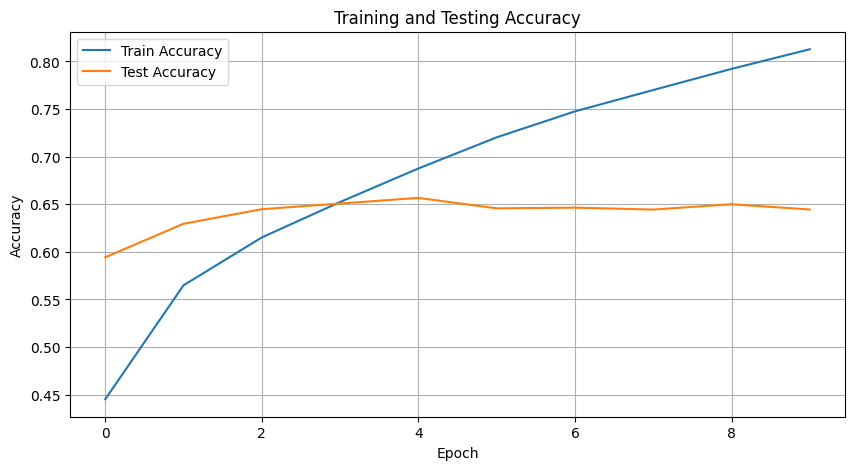

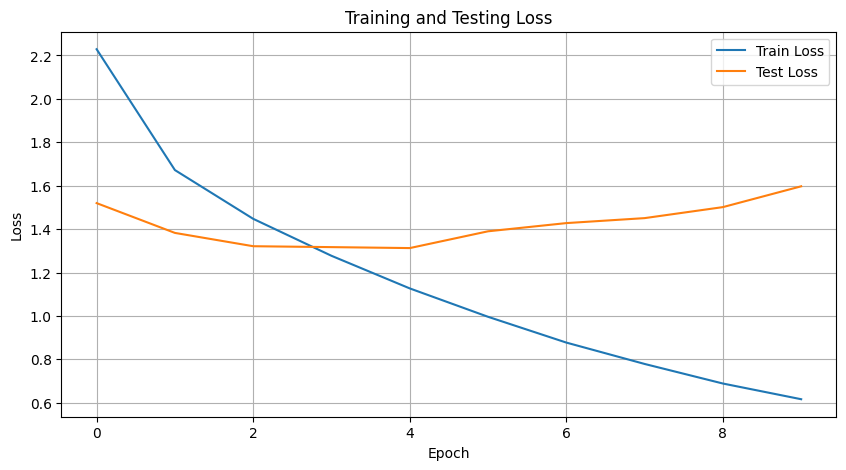

In [26]:
# Visualise the final results of the MobileNet model in Part B
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(test_accuracy_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.show()

In the final results of the mobilenet model, the following details are noticed:
1. The results of the testing dataset is a lot more linear as compared to Part A. The fluctuations in accuracy do not occur anymore and the seen results are a lot more reliable. This indicates the freezing and unfreezing of layers has solved the problem of overfitting.
2. The Mobilenet model has performed well in part B considering the dataset size difference going from 5 classes to 101 classes, denoting an overall image size rise from 5,000 images to a 101,000 images.
3. The test loss first lowers from 1.5197 to 1.3125 before increasing significantly to 1.5971. This trend indicates that the model initially generalises well to new data but may begin to overfit as training proceeds. The test accuracy rises from 59.43% to 64.45%, demonstrating that the model's performance on unknown data improves with each epoch but may plateau near the end.

